In [1]:
%pylab inline

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

Populating the interactive namespace from numpy and matplotlib


# Chapter 4 Understanding the Training Models

This chapter describes some of the machine learning models used in chapters 2 and 3. It starts with Linear regresion.
First approach is to solve the cost function for a linear regresion model
See page 110 for the equations.

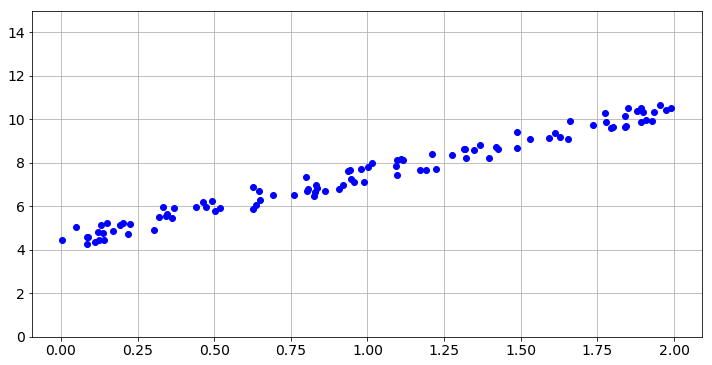

In [2]:
plt.rcParams['figure.figsize']=12,6
plt.rcParams['font.size']=14
X = 2 * np.random.rand(100,1)
y = 4 + 3*X + np.random.rand(100,1)

h=plot(X,y,'bo')
ylim(0,15)
grid()

Now we will compute the parameters for the linear model using the analytical solution

In [3]:
X_b = np.c_[np.ones((100,1)),X] # add x0=1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.43461408],
       [3.03708958]])

The real values are 4 and 3. Gaussain noise doesn't let us recover the exact parameters but close enough

Now we can make predictions using the "learned" parameters

In [4]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new] # add x0=1 to each instance
y_predict = X_new_b.dot(theta_best)

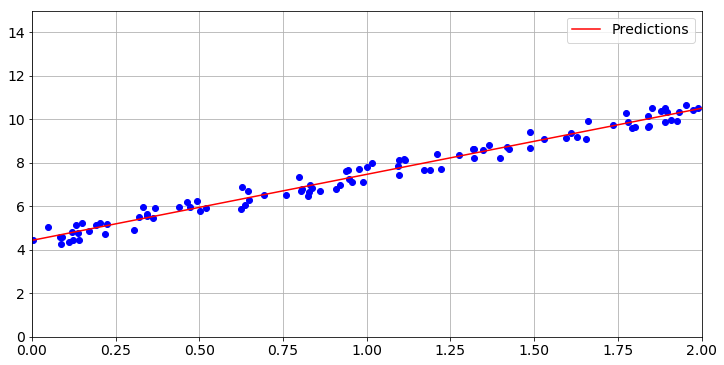

In [5]:
h=plot(X,y,'bo')
g=plot(X_new,y_predict,'r-',label='Predictions')
ylim(0,15)
xlim(0,2)
grid()
legend()

## Using Scikit-Learn

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_,lin_reg.coef_

(array([4.43461408]), array([[3.03708958]]))

Same as before :)

Another way is to usec scipy, which scikit is based on

In [8]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b,y,rcond=1e-6)
theta_best_svd

array([[4.43461408],
       [3.03708958]])

In [9]:
# using the pseudo invers
np.linalg.pinv(X_b).dot(y)

array([[4.43461408],
       [3.03708958]])

# Gradient Descent

Gradient descent is a numerical approximation to find the minimum of the cost function. It tweaks the parameters in the direction of decreasing of the cost function.

In [10]:
theta_path_bgd = []

eta = 0.1 #learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization

for iteration in xrange(n_iterations):
    gradients = 2 * X_b.T.dot(X_b.dot(theta) - y) / m
    theta = theta - eta * gradients
    
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

In [11]:
theta

array([[4.43461408],
       [3.03708958]])

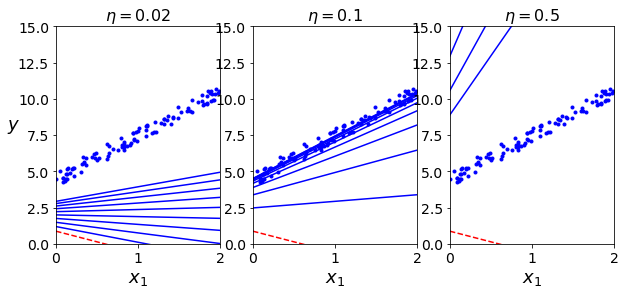

In [12]:
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

As can be seen this uses all the data as in `X_b`. Using the **Stochastic Gradient Descent** you can use one piece of data at every step of the iteration. This is good for large training sets, making the training faster

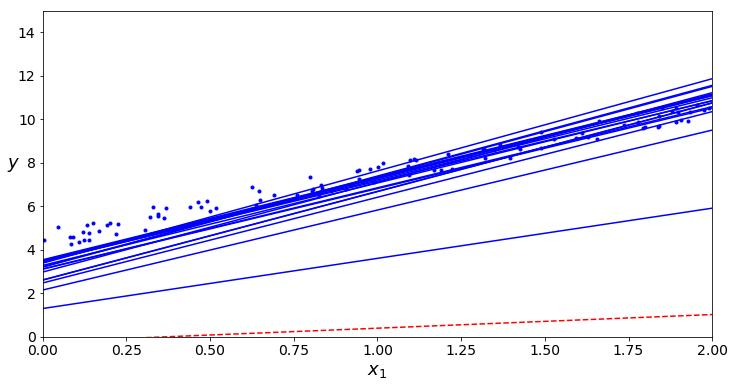

In [13]:
theta_path_sgd = []
m = len(X_b)

n_epochs = 50 
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0/(t+t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in xrange(n_epochs):
    for i in xrange(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
plt.show()                                           # not shown

In [14]:
theta

array([[4.42165578],
       [3.04424546]])

I was having troubles with this, and found out it was the learning schedule which was using `ints`. I fixed this by using the `division` from the `__future__` package to support python 2 and 3 functionality 

Scikit Learn has stochastic GD. 

In [15]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50,penalty=None,eta0=0.1,tol=1e-3)
sgd_reg.fit(X,y.ravel())
sgd_reg.intercept_,sgd_reg.coef_

(array([4.40582697]), array([3.02712413]))

**Mini-batch GD** using a small sample of the training set chosen randomly

In [16]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

theta = np.random.rand(2,1)

t0,t1 = 200,1000
def learning_schedule(t):
    return t0/(t+t1)

t=0
for epoch in xrange(n_iterations):
    shuffled_indices = np.random.permutation(m) #randomize indices of the training set
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y [shuffled_indices]
    for i in range(0,m,minibatch_size):
        t+=1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2 *xi.T.dot(xi.dot(theta)-yi) / minibatch_size
        eta = learning_schedule(t)
        theta = theta - eta*gradients
        theta_path_mgd.append(theta)

In [17]:
theta

array([[4.44784117],
       [3.05039012]])

In [18]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

[2.5, 4.5, 2.3, 3.9]

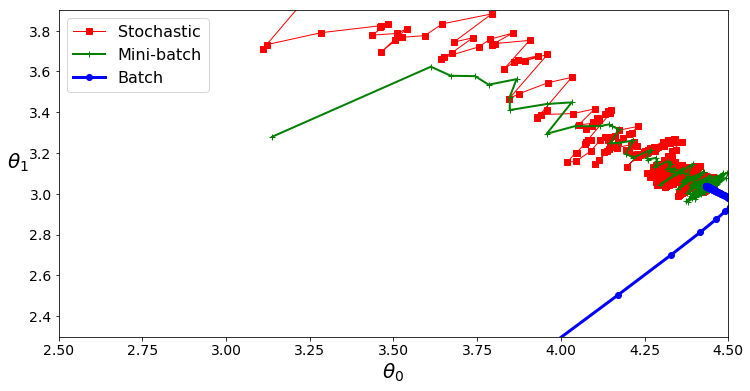

In [19]:
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])


# Polynomial Regresion

If data is more complicated, add features  as powers of each feature. The MSE will keep been linear in the parameter space. 

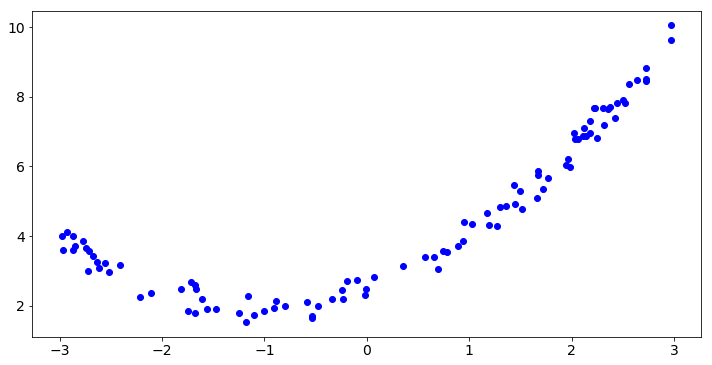

In [20]:
m = 100
X = 6*np.random.rand(m,1)-3
y = 0.5 * X**2 + X +2 + np.random.rand(m,1)
plot(X,y,'bo')

In [21]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2,include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-2.74477175])

In [22]:
X_poly[0]

array([-2.74477175,  7.53377197])

In [23]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly,y)
lin_reg.intercept_,lin_reg.coef_

(array([2.50400873]), array([[0.99772913, 0.49034258]]))

In [24]:
X_new = np.linspace(-3,3,m).reshape(100,1)
print(X_new[0])
X_new = poly_features.fit_transform(X_new)
X_new[0]

[-3.]


array([-3.,  9.])

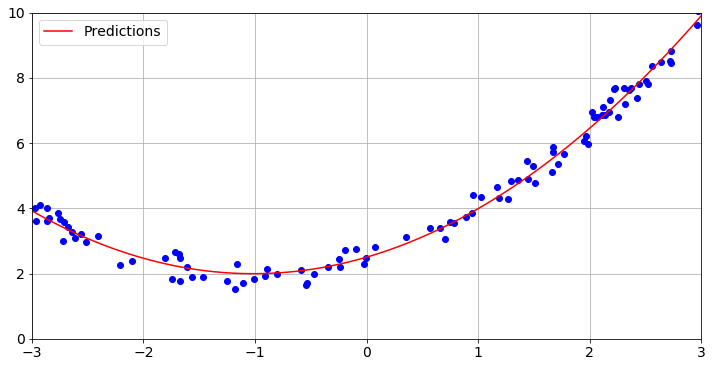

In [25]:
X_new = np.linspace(-3,3,m).reshape(100,1)
X_new_pol = poly_features.fit_transform(X_new)
y_predict = lin_reg.predict(X_new_pol)
h=plot(X,y,'bo')
g=plot(X_new,y_predict,'r-',label='Predictions')
xlim(-3,3)
ylim(0,10)
grid()
legend()

# Learning curves

[-3, 3, 0, 10]

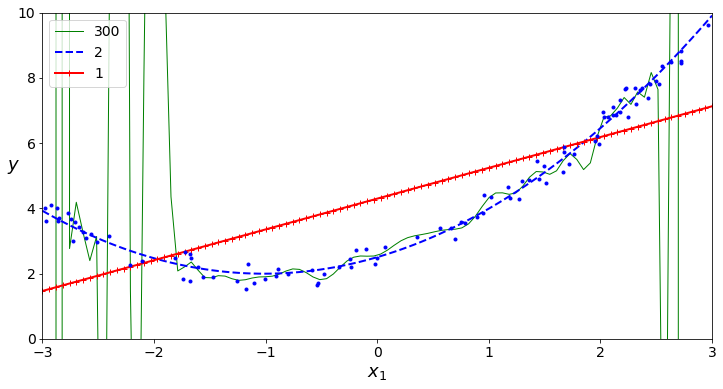

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [28]:
def plot_learning_curves(model,X,y):
    X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2)
    train_errors, val_errors = [],[]
    for m in xrange(1,len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
        val_errors.append(mean_squared_error(y_val,y_val_predict))
    plot(np.sqrt(train_errors),'r-+',label='training set')
    plot(np.sqrt(val_errors),'b-',label='validation set')
    xlabel("Set size")
    ylabel("RMSE")
    ylim(0,3)
    legend()
    grid(ls=":")

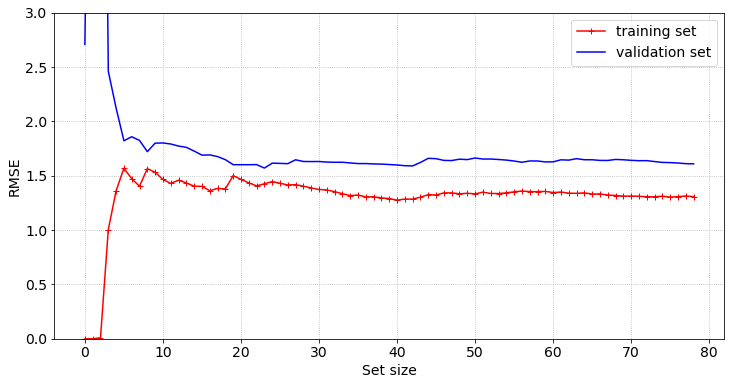

In [29]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg,X,y)

Training set has a zero RMSE when the set size is low. (e.g.Perfect model in two points). It reaches a plateu after size increases. More data won't help. Validation starts high but gets smaller with more data. There might be underfitting, both curves are clos and high at the end. 

In [30]:
from sklearn.pipeline import Pipeline

In [31]:
polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10,include_bias=False)),
    ("lin_reg",LinearRegression()),
])

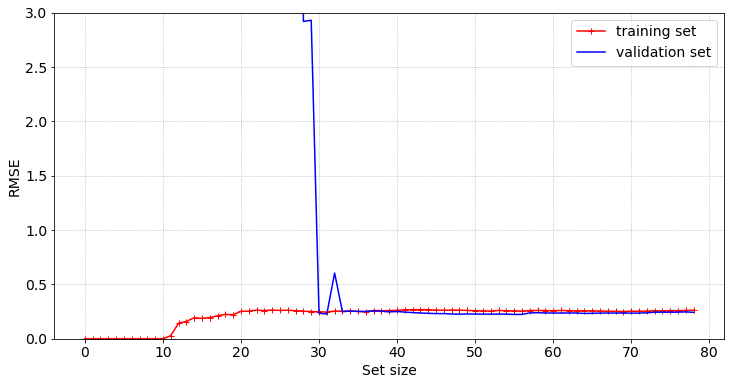

In [32]:
plot_learning_curves(polynomial_regression,X,y)

Compared to previous one, the polynomail model with higher degree has a smaller RMSE. There might overfitting since even tho they are in a plateau now, there's a constant gap, not reducing with more data. 

# Regularized Linear Models
## Ridge Regression

Add a regularization term during training. Take it out afterwards. Uses half of the norm of the parameter vector as regularization. (squared, $l_2$ norm)

$ \frac{1}{2} \alpha \sum_i \theta_i^2 $

In [33]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1,solver='cholesky')
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[5.71068992]])

In [34]:
sgd_reg = SGDRegressor(penalty='l2',max_iter=50)
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

/Users/hugo/Software/miniconda2/envs/st_test/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


array([5.72602544])

In [35]:
ridge_reg = Ridge(alpha=1,solver='sag')
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[5.70935022]])

## Lasso Regression

Uses the sum of the absolute of the parameters as regularization ($l_1$ norm)

$ \frac{1}{2} \alpha \sum_i |\theta_i| $

In [36]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([5.67829558])

## Elastic Net

Combines both Ridge and Lasso Regression in one cost function. It usues a mix ratio variable $r$.

In [37]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1,l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([5.67977826])

# Early Stopping

After the minimum has been found we can stop training to save time

In [38]:
from sklearn.base import clone

In [39]:
# create fake data
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

# prepare data
poly_scaler = Pipeline([
    ("poly_features",PolynomialFeatures(degree=90,include_bias=False)),
    ("std_scaler",StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

In [40]:
sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty=None,learning_rate='constant',eta0=0.0005,random_state=42,tol=-np.infty)
#warm start makes the training continue where it left off instead of restarting from scratch. 

Text(0,0.5,u'RMSE')

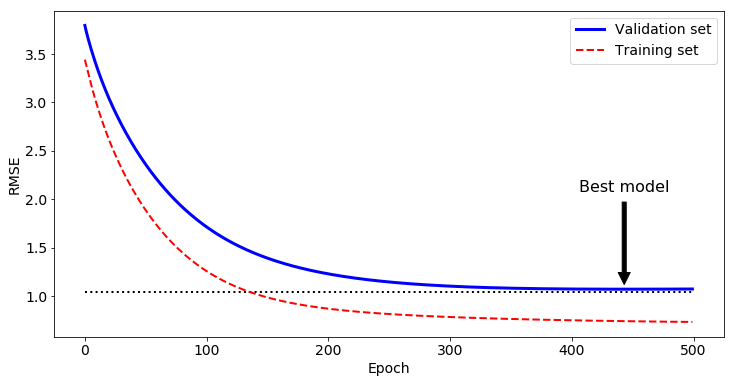

In [41]:
n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

In [43]:
best_epoch

443

## Logisitc Regression

This linear model can be used also for classification (WUUUT?). Although not a proper probability, it can be used as that to decide what label to put on different items.

[-10, 10, -0.1, 1.1]

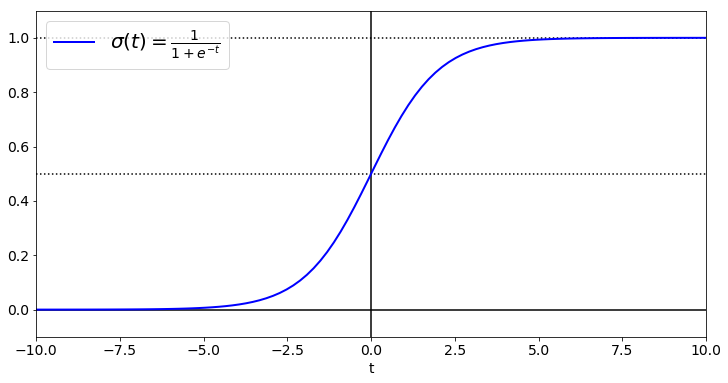

In [44]:
t = linspace(-10,10,100)
sig = 1 / (1+np.exp(-t))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])

In [45]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['target', 'DESCR', 'target_names', 'feature_names', 'data', 'filename']

In [46]:
X = iris["data"][:,3:] # petal width
y = (iris["target"]==2).astype(np.int) # 1 if Iris-Virginica, else 0

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None,
          solver=u'liblinear', tol=0.0001, verbose=0, warm_start=False)

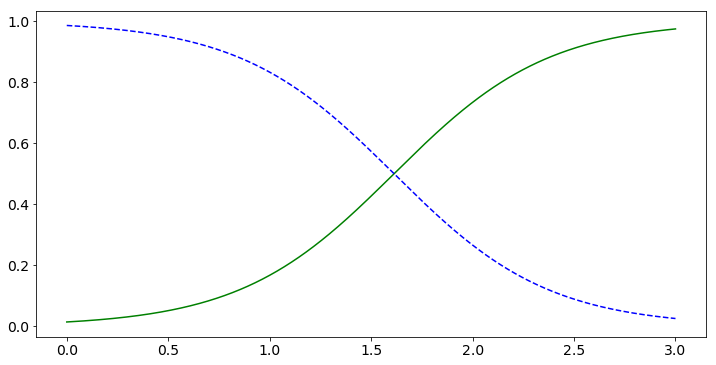

In [49]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plot(X_new,y_proba[:,1],"g-",label="iris-virginica")
plot(X_new,y_proba[:,0],"b--",label="Others")

[0, 3, -0.02, 1.02]

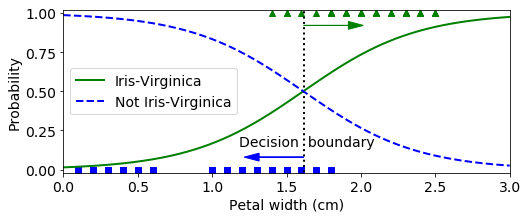

In [50]:
plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])

In [52]:
log_reg.predict([[1.7],[1.5]])

array([1, 0])

In [75]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

#C = 1/alpha; higher value of C means less regularzied. Here width and length are the same order of magnitude so we want less. 
log_reg=LogisticRegression(solver="liblinear",C=10**10,random_state=42)
log_reg.fit(X,y)

LogisticRegression(C=10000000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver=u'liblinear', tol=0.0001, verbose=0, warm_start=False)

(0.8, 2.7)

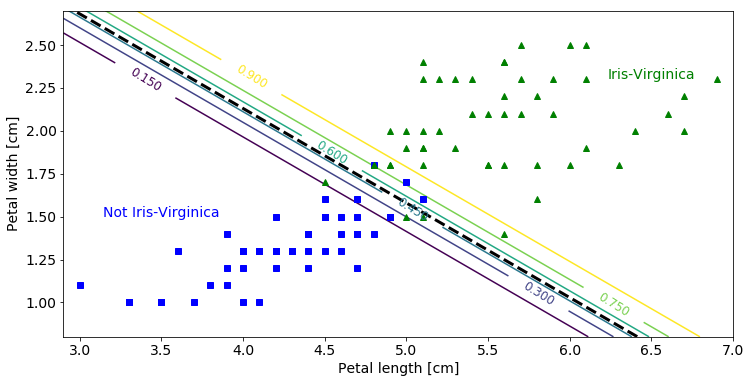

In [83]:
x0,x1 = np.meshgrid(
        np.linspace(2.9,7,500).reshape(-1,1),
        np.linspace(0.8,2.7,200).reshape(-1,1),
    )
X_new = np.c_[x0.ravel(),x1.ravel()]

y_proba = log_reg.predict_proba(X_new)
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:,1].reshape(x0.shape)
contour = plt.contour(x0,x1,zz)

left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]
plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)

plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length [cm]", fontsize=14)
plt.ylabel("Petal width [cm]", fontsize=14)

plt.xlim(2.9,7.0)
plt.ylim(0.8,2.7)

## Softmax Regression

Also called Multinomial Logisitic Regression. Used for multiple classification. It computes a score for each class $k$, then estimates the probability of each class by using a normalized exponential to the scores. 

Each class has it's own dedicatec parameter vector, and they can be stored in rows of a parameter matrix. 

It cannot, however, predict more than class at a time (multiclass, no multioutput).

In [89]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

#C = 1/alpha; higher value of C means less regularzied. Here width and length are the same order of magnitude so we want less. 
softmax_reg=LogisticRegression(solver="lbfgs",C=10,random_state=42,multi_class='multinomial')
softmax_reg.fit(X,y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class=u'multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver=u'lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [90]:
softmax_reg.predict([[5,2]])

array([2])

In [91]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

[0, 7, 0, 3.5]

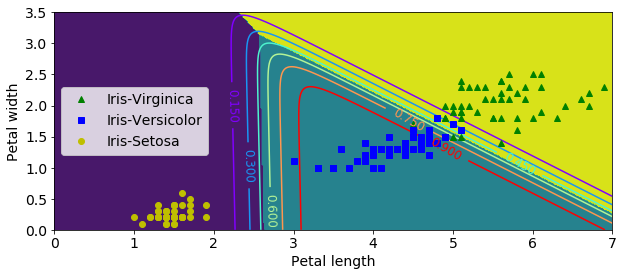

In [107]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

plt.contourf(x0, x1, zz)
contour = plt.contour(x0, x1, zz1,cmap=plt.cm.rainbow)
plt.clabel(contour, inline=1, fontsize=12)

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])

In [108]:
softmax_reg.get_params

<bound method LogisticRegression.get_params of LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class=u'multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver=u'lbfgs',
          tol=0.0001, verbose=0, warm_start=False)>